In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import argparse
import logging
import shutil
import re
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torchvision.datasets import VisionDataset
from torchvision import transforms
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from utils import *
from auto_tqdm import tqdm
import augmentations
%matplotlib inline

DATA_DIR = '/data/amiratag/prostate'
MEM_DIR = '/home/amiratag/Projects/sslp'

DATA_DIR = "/export/medical_ai/kaggle_panda" # Stores data related to images
MEM_DIR = "/export/home/code/metamind/precision_oncology/simclr" #stores data related to model checkpoints

In [2]:
def return_embeddings(slide, mask):
    ''' Function that transforms a slide into the tensor with 128 channels.'''
    width, height = slide.shape[:2]
    embeddings = np.zeros((width // im_shape[0], height // im_shape[1], embedding_size)).astype(np.float32)
    batch, w_idxs, h_idxs = [], [], []
    for w in range(embeddings.shape[0]):
        for h in range(embeddings.shape[1]):
            
            tile_mask = mask[w * im_shape[0]: (w+1) * im_shape[0], h * im_shape[1]: (h+1) * im_shape[1], 0]
            if np.mean(np.equal(tile_mask, 0)) < 0.95:
                tile = slide[w * im_shape[0]: (w+1) * im_shape[0], h * im_shape[1]: (h+1) * im_shape[1]] / 255.
                batch.append(torch.tensor(tile.astype(np.float32).transpose(2,0,1)))
                w_idxs.append(w)
                h_idxs.append(h)
            if len(batch) == batch_size or \
            (w == embeddings.shape[0] - 1 and h == embeddings.shape[1] - 1):
                if not len(batch):
                    continue
                X = torch.stack(batch).to(device)
                pred = model(X).detach().cpu().numpy()
                embeddings[w_idxs, h_idxs] = pred
                batch, w_idxs, h_idxs = [], [], []
    return embeddings

Read data

In [3]:
dataset = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
valid_idxs = np.array([i for i in range(len(dataset)) if dataset['data_provider'][i] == 'radboud' and
                       os.path.exists(os.path.join(DATA_DIR, 'train_images', dataset['image_id'][i])+'.tiff')])
train_idxs = valid_idxs[:-1000]
test_idxs = valid_idxs[-1000:]

train_slides = dataset['image_id'][train_idxs].values
train_isup_dic = dict(zip(train_slides, dataset['isup_grade'][train_idxs]))
test_slides = dataset['image_id'][test_idxs].values
test_isup_dic = dict(zip(test_slides, dataset['isup_grade'][test_idxs]))

In [4]:
cudnn.benchmark = True
use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if use_cuda else 'cpu'

Load and run patch level model

In [5]:
model_dir = os.path.join(MEM_DIR, 'simclr/translationrotation')

In [6]:
im_shape = (224, 224)
embedding_size = 128
model = ResNetSimCLR('resnet34', embedding_size)
if use_cuda:
    model = torch.nn.DataParallel(model).cuda()
checkpoints = [i for i in os.listdir(model_dir) if '.pt' in i]
checkpoints_epoch_num = [int(re.search('epoch(\d+)', c).group(1)) for c in checkpoints]
last_epoch = np.max(checkpoints_epoch_num)
checkpoint = torch.load(os.path.join(model_dir, 'checkpoint-epoch{}.pt'.format(last_epoch)))
print('Loading checkpoint from epoch #{}'.format(last_epoch))
state_dict = checkpoint.get('state_dict', checkpoint)
model.load_state_dict(state_dict)
model.eval()

resnet34
Loading checkpoint from epoch #164


DataParallel(
  (module): ResNetSimCLR(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

Computed and save training slides embeddings

In [7]:
batch_size = 320
overwrite = False
save_dir = 'simclr_translationrotation_predicted_masks'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [13]:
for i, train_slide in tqdm(enumerate(train_slides)):
    image_path = os.path.join(DATA_DIR, 'train_images', train_slide)+'.tiff'
    mask_path = os.path.join(DATA_DIR, 'train_label_masks', train_slide)+'_mask.tiff'
    save_path = os.path.join(save_dir, train_slide + '.npy')
    
    if os.path.exists(save_path) and not overwrite:
        continue
    
    try:
        slide = io.imread(image_path)
        mask = io.imread(mask_path)
    except:
        continue
    
    embeddings = return_embeddings(slide, mask)
    np.save(save_path, embeddings)

Computed and save test slides embeddings

In [16]:
save_dir = 'test_simclr_translationrotation_predicted_masks'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [17]:
for i, test_slide in tqdm(enumerate(test_slides)):
    image_path = os.path.join(DATA_DIR, 'train_images', test_slide)+'.tiff'
    mask_path = os.path.join(DATA_DIR, 'train_label_masks', test_slide)+'_mask.tiff'
    save_path = os.path.join(save_dir, test_slide + '.npy')
    
    if os.path.exists(save_path) and not overwrite:
        continue
    
    try:
        slide = io.imread(image_path)
        mask = io.imread(mask_path)
    except:
        continue
    
    embeddings = return_embeddings(slide, mask)
    np.save(save_path, embeddings)

Create slide-level dataset

In [8]:
image_names = os.listdir('simclr_translationrotation_predicted_masks')
X, y = [], []
for image_name in train_slides:
    pm_path = os.path.join('simclr_translationrotation_predicted_masks', image_name+'.npy')
    if os.path.exists(pm_path):
        X.append(pm_path)
        y.append(train_isup_dic[image_name])
X_test, y_test = [], []
for image_name in test_slides:
    pm_path = os.path.join('test_simclr_translationrotation_predicted_masks', image_name+'.npy')
    if os.path.exists(pm_path):
        X_test.append(pm_path)
        y_test.append(test_isup_dic[image_name])
X, y, X_test, y_test = np.array(X), np.array(y), np.array(X_test), np.array(y_test)

Slide-level ConvNet

In [9]:
class CustomDataset(VisionDataset):
    
    def __init__(self, X, y):
        
        super(CustomDataset, self).__init__('', transform=None,
                                      target_transform=None)
        self.X = X
        self.y = y
        assert len(self.X) == len(self.y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        
        img, target = self.X[index], self.y[index]
        output = np.zeros((224, 224, 128)).astype(np.float32)
        loaded_image = np.load(img)
        shape = loaded_image.shape[:2]
        r1 = np.random.choice(224 - shape[0])
        r2 = np.random.choice(224 - shape[1])
        output[r1:loaded_image.shape[0]+r1, r2:loaded_image.shape[1]+r2] = loaded_image
        output = torch.Tensor(output.transpose((2,0,1)))
        return output, target
    
    def extra_repr(self):
        return "Split: {}".format("Train" if self.train is True else "Test")
    
def train(device, model, train_loader, optimizer, epoch):
    
    model.train()
    train_metrics = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        logits = model(data)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        optimizer.step()
        
        train_metrics.append(dict(
            epoch=epoch,
            loss=loss.item()))
        print(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader) * batch_size,
                       100. * batch_idx / len(train_loader), loss.item()))
    return train_metrics

class ConvLayer(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1):

        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                                    stride=stride)
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)

    def forward(self, x):

        h = self.conv(x)
        h = self.bn(h)
        h = self.relu(h)
        return h

class MiniModel(nn.Module):

    def __init__(self, num_classes):

        super().__init__()
        self.cl1_1 = ConvLayer(128, 128, 3, 1)
        self.cl1_2 = ConvLayer(128, 128, 3, 1)
        self.cl2_1 = ConvLayer(128, 128, 3, 1)
        self.cl2_2 = ConvLayer(128, 128, 3, 1)
        self.cl3_1 = ConvLayer(128, 128, 3, 1)
        self.cl3_2 = ConvLayer(128, 128, 3, 1)
        self.fc = torch.nn.Linear(128, num_classes)


    def forward(self, x):

        h = self.cl1_1(x)
        h = self.cl1_2(h)
        h = torch.nn.MaxPool2d(3, 3)(h)
        h = self.cl2_1(h)
        h = self.cl2_2(h)
        h = torch.nn.MaxPool2d(3, 3)(h)
        h = self.cl3_1(h)
        h = self.cl3_2(h)
        h = torch.nn.MaxPool2d(3, 3)(h)
        h = torch.mean(h, axis=(-1, -2))
        return self.fc(h)
    

In [10]:
batch_size = 64

In [11]:
train_dataset = CustomDataset(X, y)
test_dataset = CustomDataset(X_test, y_test)
kwargs = {'num_workers': 12, 'pin_memory': False} if use_cuda else {}
kwargs = {}
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)
test_loader =  DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [1]:
model = MiniModel(num_classes=6)
if use_cuda:
    model = torch.nn.DataParallel(model).cuda()
optimizer = optim.SGD(model.parameters(), lr=0.05,
                      momentum=0.9,
                      weight_decay=5e-4,
                      nesterov=True)

NameError: name 'MiniModel' is not defined

In [13]:
for epoch in range(0, 50):
    
    if epoch % 5 == 0:
        model.eval()
        true, predicted = [], []
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            logits = model(data)
            predicted.append(logits.argmax(-1).detach().cpu().numpy())
            true.append(target.detach().cpu().numpy())
        print(np.mean(np.concatenate(predicted) == np.concatenate(true)))
    
    lr = 0.05 * 0.5 * (1 + np.cos((epoch - 1) / 50 * np.pi))
    print('Setting learning rate to %g' % lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    train(device, model, train_loader, optimizer, epoch)

0.20266120777891505
Setting learning rate to 0.0499507
Train Epoch: 0 [0/4032 (0%)]	Loss: 1.956875
Train Epoch: 0 [64/4032 (2%)]	Loss: 1.805432
Train Epoch: 0 [128/4032 (3%)]	Loss: 1.913801
Train Epoch: 0 [192/4032 (5%)]	Loss: 1.986511
Train Epoch: 0 [256/4032 (6%)]	Loss: 1.861092
Train Epoch: 0 [320/4032 (8%)]	Loss: 1.814164
Train Epoch: 0 [384/4032 (10%)]	Loss: 1.780331
Train Epoch: 0 [448/4032 (11%)]	Loss: 1.864194
Train Epoch: 0 [512/4032 (13%)]	Loss: 1.749207
Train Epoch: 0 [576/4032 (14%)]	Loss: 1.788651


KeyboardInterrupt: 

In [14]:
model.eval()
true, predicted = [], []
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    logits = model(data)
    predicted.append(logits.argmax(-1).detach().cpu().numpy())
    true.append(target.detach().cpu().numpy())
print(np.mean(np.concatenate(predicted) == np.concatenate(true)))

0.18730808597748208


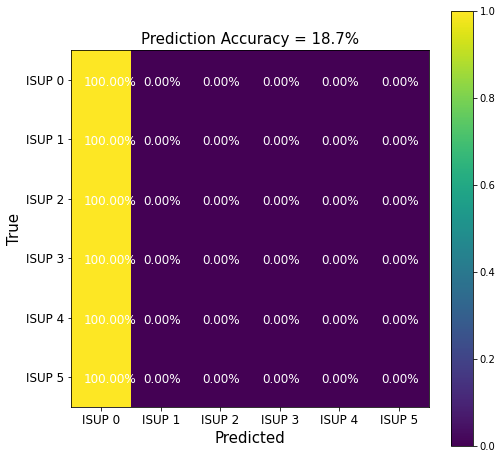

In [15]:
from sklearn.metrics import confusion_matrix
fig = plt.figure(figsize=(8, 8))
cm = confusion_matrix(np.concatenate(true), np.concatenate(predicted))
normalized_cm = cm/np.sum(cm, -1, keepdims=True)
plt.imshow(normalized_cm, vmin=0., vmax=1)
plt.imshow(normalized_cm, vmin=0., vmax=1)
plt.colorbar()
plt.xticks(np.arange(6), ['ISUP {}'.format(i) for i in range(6)], fontsize=12)
plt.yticks(np.arange(6), ['ISUP {}'.format(i) for i in range(6)], fontsize=12)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.title('Prediction Accuracy = {0:.1f}%'.format(100 * np.mean(np.concatenate(true) == np.concatenate(predicted))), fontsize=15)
for i in range(6):
    for j in range(6):
        plt.annotate('{0:.2f}%'.format(100 * normalized_cm[i, j]), (j-0.3, i+0.1), color='white', fontsize=12)

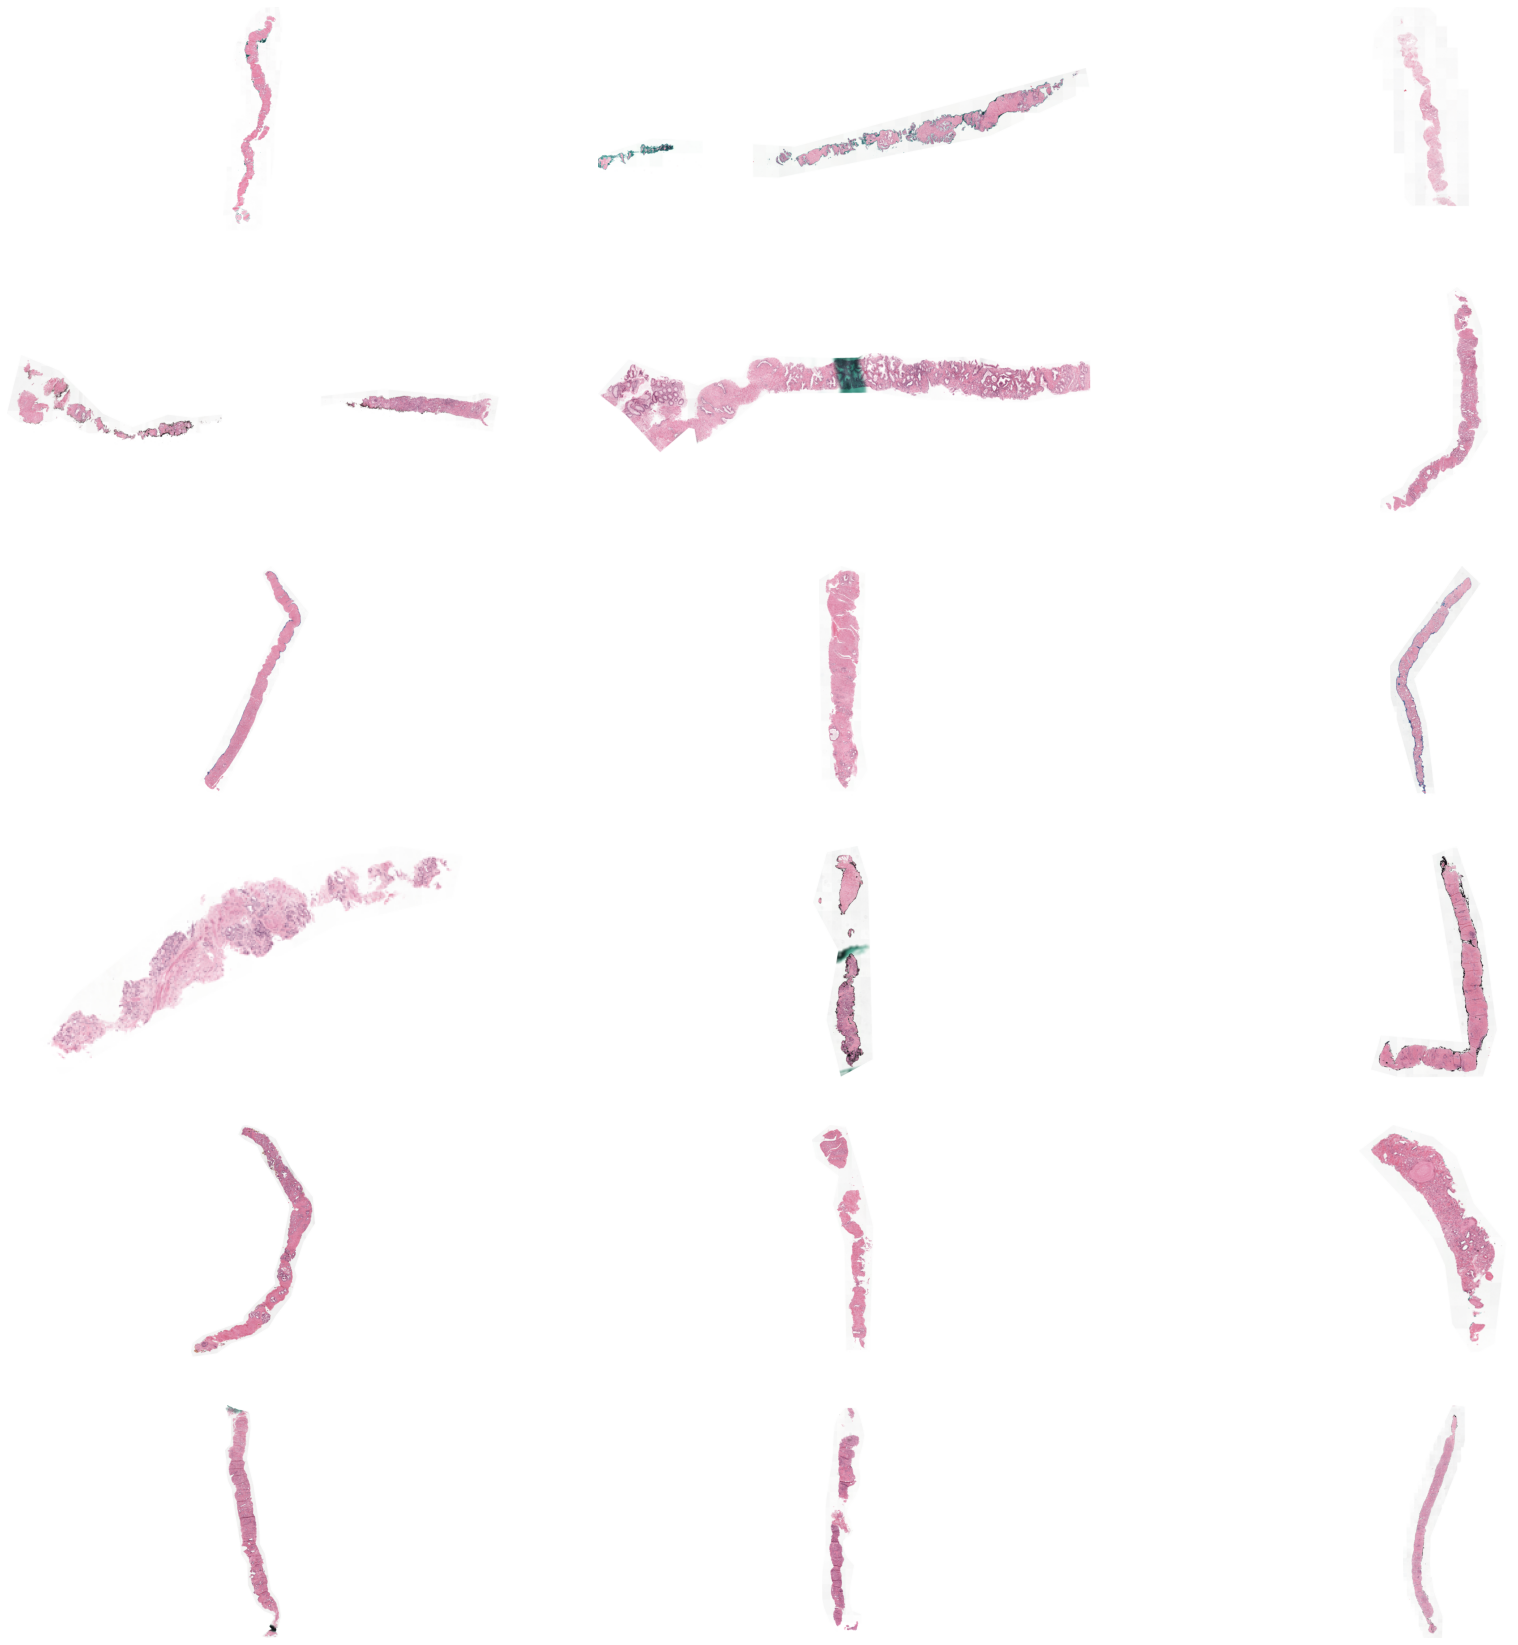

In [26]:
fig = plt.figure(figsize=(30, 30))
isups = np.array([train_isup_dic[train_slide] for train_slide in train_slides])
for i in range(6):
    idxs = np.where(isups == i)[0]
    for j in range(3):
        
        plt.subplot(6, 3, 3 * i + j + 1)
        slide = io.imread(os.path.join(DATA_DIR, 'train_images', train_slides[np.random.choice(idxs)]) + '.tiff')
        plt.imshow(Image.fromarray(slide).resize((slide.shape[1] // 20, slide.shape[0]//20)))
        plt.axis('off')

Semi-supervised learning (assume 10000 tiles are labeled)

In [16]:
from sklearn.cluster import KMeans
predicted_masks = os.listdir(save_dir)
all_dims = []
for predicted in tqdm(predicted_masks):
    all_dims.append(np.load(os.path.join(save_dir, predicted)).reshape((-1, 128)))
all_dims = np.concatenate(all_dims)
km = KMeans(50, verbose=3, max_iter=20, n_init=1)
km.fit(all_dims)
centers = km.cluster_centers_

Initialization complete
Iteration 0, inertia 252522.8336856963
Iteration 1, inertia 205220.08014272182
Iteration 2, inertia 197674.76997302298
Iteration 3, inertia 195498.77405551096
Iteration 4, inertia 194271.65788506455
Iteration 5, inertia 193417.70055152354
Iteration 6, inertia 192776.6363741704
Iteration 7, inertia 192274.1029602169
Iteration 8, inertia 191878.64026615306
Iteration 9, inertia 191536.9278956728
Iteration 10, inertia 191233.29799611063
Iteration 11, inertia 190965.65913409015
Iteration 12, inertia 190729.86660358866
Iteration 13, inertia 190521.02002647982
Iteration 14, inertia 190333.89635451767
Iteration 15, inertia 190172.2677284016
Iteration 16, inertia 190032.6267826647
Iteration 17, inertia 189913.337473682
Iteration 18, inertia 189807.86750305144
Iteration 19, inertia 189715.64217336927


KMeans(max_iter=20, n_clusters=50, n_init=1, verbose=3)

In [41]:
profiles = np.zeros((len(predicted_masks), len(centers)))
labels = []
for i, predicted in tqdm(enumerate(predicted_masks)):
    predicted_mask = np.load(os.path.join(save_dir, predicted)).reshape((-1, 128))
    distances = np.linalg.norm(np.expand_dims(predicted_mask, 1) - np.expand_dims(centers, 0), axis=-1)
    assignments = np.argmin(distances, -1)
    idxs, counts = np.unique(assignments, return_counts=True)
    profiles[i, idxs] = counts / np.sum(counts)
    labels.append(isup_dic[predicted.replace('.npy', '')])

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
lr = LogisticRegression()
cross_val_score(lr, np.stack(profiles, 0), np.stack(labels, 0), cv=5)

array([0.27210884, 0.23809524, 0.26530612, 0.19727891, 0.28082192])

In [ ]:
representations = []
tiles = []
for i in tqdm(range(1000)):
    image_path, mask_path = image_paths[i], mask_paths[i]
    image_name = image_path.split('/')[-1].split('.')[0]
    try:
        slide = io.imread(image_path)
        mask = io.imread(mask_path)
    except:
        continue
    if os.path.exists(save_path) and not overwrite:
        continue
    size = slide.shape
    while True:
        w = np.random.choice(size[0] // im_shape[0])
        h = np.random.choice(size[1] // im_shape[1])
        msk = mask[w * im_shape[0]: (w+1) * im_shape[0], h * im_shape[1]: (h+1) * im_shape[1]][..., 0]
        if np.mean(np.equal(msk, 0)) > 0.95:
            continue
        tile = slide[w * im_shape[0]: (w+1) * im_shape[0], h * im_shape[1]: (h+1) * im_shape[1]] / 255.
        tiles.append(tiles)
        X = torch.stack([torch.tensor(tile.astype(np.float32).transpose(2,0,1))])
        if use_cuda:
            X = X.to(device)
            representations.append(model(X).detach().cpu().numpy())
        break

In [ ]:
fig = plt.figure(figsize=(12, 12))
i = 0
idxs = np.where(assignments == i)[0]
for n in range(16):
    plt.subplot(4, 4, n+1)
    plt.imshow(tiles[idxs[n]])
    plt.axis('off')

(-0.5, 2251.5, 1381.5, -0.5)

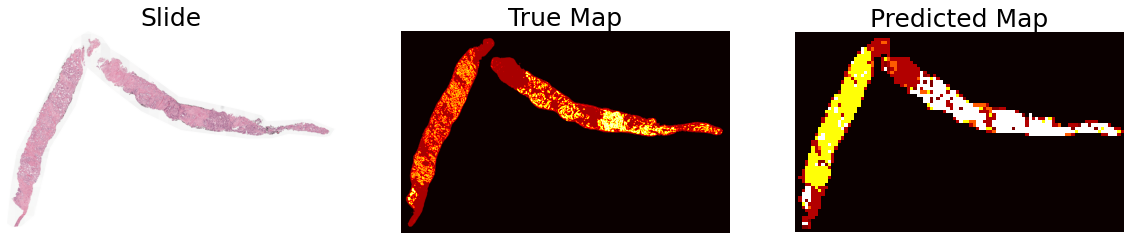

In [10]:
i = 10
fig = plt.figure(figsize=(20, 20))
image_name = image_paths[i].split('/')[-1].split('.')[0]
msk = io.imread(mask_paths[i])
img = io.imread(image_paths[i])
size = msk.shape
plt.subplot(1, 3, 3)
plt.title('Predicted Map', fontsize=25)
predicted_mask = np.load(os.path.join('predicted_masks', image_name+'.npy'))
plt.imshow((predicted_mask * 60).astype(np.uint8), cmap='hot')
plt.axis('off')
plt.subplot(1, 3, 1)
plt.title('Slide', fontsize=25)
plt.imshow(np.array(Image.fromarray(img).resize((size[1]//10, size[0]//10))))
plt.axis('off')
plt.subplot(1, 3, 2)
msk = io.imread(mask_paths[i])
size = msk.shape
plt.title('True Map', fontsize=25)
plt.imshow(np.array(Image.fromarray(msk * 60).resize((size[1]//10, size[0]//10)))[..., 0], cmap='hot')
plt.axis('off')